<a href="https://colab.research.google.com/github/konkuk-gaegul/2nd-Team-Project/blob/main/Feature_Set_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
!pip install lightgbm
!pip install xgboost
!pip install eli5 shap catboost
!pip install catboost
!pip install category_encoders

In [ ]:
import tensorflow as tf

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# ML
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# ensemble(bagging)
from sklearn.ensemble import ( 
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
)

#ensemble(boosting)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

#stacking
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, StackingRegressor

# 평가
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report

# 교차검증
from sklearn.model_selection import (
  KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, train_test_split
)

# Feature Selection
from sklearn.feature_selection import RFE, RFECV

# 시각화(SVM은 회귀계수가 나오지 않습니다.)
import eli5
from eli5.sklearn import PermutationImportance
import shap

# 트리 시각화
import graphviz

# 인코딩
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

# train & test 불러오기

In [ ]:
train_path = '/content/drive/MyDrive/data/credit/rawData/train.csv'
test_path = '/content/drive/MyDrive/data/credit/rawData/test.csv'

# 데이터 가공

## 함수 부분

In [ ]:
# day를 year로 변경해주는 함수
def days_to_year(x):
    return (x*-1)/365

# 마이너스 변환
def minus(x):
    return x * -1

In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
def numeric(df):

# 1. 의미없는 변수 제거 : index, FLAG_MOBIL, child_num
    df.drop(['index', 'FLAG_MOBIL', 'child_num'], axis=1, inplace = True)

# 2. 이상치 처리
    # 가족수 9명 이상, 6개 자료 삭제 및 인덱스 재설정 
    df = df[ ( df['family_size'] <= 7 ) ]
    df = df.reset_index(drop=True)

# 3. 결측치 처리
    # 첫 째, 결측치 & 근무일이 양수 & 연금수령자 인 경우 retiree(퇴직자)
    # 둘 째, 결측치 & 근무일이 음수인 경우 다양한 income_type 분포로 인해 No response처리
    df.loc[ (df.occyp_type.isna() == True) & (df.DAYS_EMPLOYED > 0) & 
           (df.income_type == 'Pensioner'), 'occyp_type' ] = 'retiree'
    df['DAYS_EMPLOYED'] = df[ 'DAYS_EMPLOYED' ].map(lambda x: 0 if x>0 else x)
    df.occyp_type.fillna('No response', inplace=True) 

# 4. log 사용
    # 음수자료를 양수로 변환
    feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
    for feat in feats:
        df[feat] = np.abs(df[feat])
        
    df['income_total'] = np.log1p(1+df['income_total'])
    df['DAYS_EMPLOYED'] = np.log1p(1+df['DAYS_EMPLOYED'])
    df['DAYS_BIRTH'] = np.log1p(1+df['DAYS_BIRTH'])
    df['begin_month'] = np.log1p(1+df['begin_month'])

# 5. 새로운 변수 ID열 생성 : 한 사람이 다수의 카드를 발급 받았을 경우
    df['ID'] = \
    df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

# 6. 라벨 인코딩 (categorical 변수를 numerical로 변환!!)
    df['gender']=LabelEncoder().fit_transform(df.gender)
    df['car']=LabelEncoder().fit_transform(df.car)
    df['reality']=LabelEncoder().fit_transform(df.reality)

    return df
# ------------------------------------------------------------------- #

In [ ]:
train = numeric(train)
test  = numeric(test)

## 인코딩

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders.ordinal import OrdinalEncoder

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  11
Number of Categorical features:  6


In [ ]:
numerical_feats

['gender',
 'car',
 'reality',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month']

In [ ]:
categorical_feats

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

In [ ]:
train.head(2)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID
0,0,0,0,12.218505,Commercial associate,Higher education,Married,Municipal apartment,9.539716,8.457655,0,0,0,No response,2.0,2.079442,1.0,12.218505042023168_9.539716058977092_8.4576554...
1,0,0,1,12.419174,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,9.339788,7.340836,0,0,1,Laborers,3.0,1.945910,1.0,12.419173941766314_9.339788439163069_7.3408355...


In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [ ]:
train.head(2)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID
0,0,0,0,12.218505,1,1,1,1,9.539716,8.457655,0,0,0,1,2.0,2.079442,1.0,1
1,0,0,1,12.419174,1,2,2,2,9.339788,7.340836,0,0,1,2,3.0,1.945910,1.0,2


In [ ]:
# 인코딩 잘되었는지 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26451 non-null  int64  
 1   car            26451 non-null  int64  
 2   reality        26451 non-null  int64  
 3   income_total   26451 non-null  float64
 4   income_type    26451 non-null  int64  
 5   edu_type       26451 non-null  int64  
 6   family_type    26451 non-null  int64  
 7   house_type     26451 non-null  int64  
 8   DAYS_BIRTH     26451 non-null  float64
 9   DAYS_EMPLOYED  26451 non-null  float64
 10  work_phone     26451 non-null  int64  
 11  phone          26451 non-null  int64  
 12  email          26451 non-null  int64  
 13  occyp_type     26451 non-null  int64  
 14  family_size    26451 non-null  float64
 15  begin_month    26451 non-null  float64
 16  credit         26451 non-null  float64
 17  ID             26451 non-null  int64  
dtypes: flo

# 모델링-1 (CatBoost)
- 오버 샘플링
    - 신용도가 상대적으로 좋을 수록 자료의 수는 적다.
- Default Parameter 사용
- 손실함수(log loss)는 구한 확률을 음의 로그함수에 대입하는 것
- 100% : log_loss = -log(1.0) = 0
-  80% : log_loss = -log(0.8) = 0.2231
-  60% : log_loss = -log(0.6) = 0.5108
    - 확률이 높을 수록 0에 가까워진다.

## 오버 + 언더 샘플링

In [ ]:
from imblearn.combine import *

In [ ]:
x = train.drop( columns=['credit'])
y = train['credit']

In [ ]:
sample = SMOTEENN()
x_smote_enn, y_smote_enn = sample.fit_resample(x, y)
np.unique(y_smote_enn, return_counts=True)

(array([0., 1., 2.]), array([11229,  9017,  7190]))

In [ ]:
train_SMOTEENN = pd.concat( [x_smote_enn, y_smote_enn ], axis=1 )

In [ ]:
train_SMOTEENN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27436 entries, 0 to 27435
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         27436 non-null  int64  
 1   car            27436 non-null  int64  
 2   reality        27436 non-null  int64  
 3   income_total   27436 non-null  float64
 4   income_type    27436 non-null  int64  
 5   edu_type       27436 non-null  int64  
 6   family_type    27436 non-null  int64  
 7   house_type     27436 non-null  int64  
 8   DAYS_BIRTH     27436 non-null  float64
 9   DAYS_EMPLOYED  27436 non-null  float64
 10  work_phone     27436 non-null  float64
 11  phone          27436 non-null  float64
 12  email          27436 non-null  float64
 13  occyp_type     27436 non-null  int64  
 14  family_size    27436 non-null  float64
 15  begin_month    27436 non-null  float64
 16  ID             27436 non-null  int64  
 17  cluster        27436 non-null  int32  
 18  credit

## 클러스터링
- 36개의 군집으로 나누어본다.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_train = train_SMOTEENN.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train_SMOTEENN['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

## StandardScale
- 평균 1, 분산 0 : N(1,0)으로 만들어준다.
- 이미 로그변환을 마친 컬럼 제외
- income_total, DAYS_EMOPLOYED, DAYS_BIRTH, begin_month

In [ ]:
from sklearn.preprocessing import StandardScaler
import multiprocessing

In [ ]:
numerical_feats.remove('income_total')
numerical_feats.remove('DAYS_EMOPLOYED')
numerical_feats.remove('DAYS_BIRTH')
numerical_feats.remove('begin_month')
scaler = StandardScaler()
train_SMOTEENN[numerical_feats] = scaler.fit_transform(train_SMOTEENN[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
numerical_feats

['DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'family_size']

## CAT BOOST

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [ ]:
# one of the parameters : cat_features
categorical_feats

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

### n_fold = 15
- Log Loss : 1.29516

In [ ]:
# n_fold를 돌려보고 좋은 수치를 선택
# n_fold = 5, 
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train_SMOTEENN.drop(target, axis=1)
y = train_SMOTEENN[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115211
0:	learn: 0.9937592	test: 0.9704501	best: 0.9704501 (0)	total: 166ms	remaining: 2m 45s
100:	learn: 0.3494958	test: 0.2140654	best: 0.2140582 (99)	total: 25.4s	remaining: 3m 46s
200:	learn: 0.3177650	test: 0.1966357	best: 0.1966357 (200)	total: 54.6s	remaining: 3m 36s
300:	learn: 0.3002641	test: 0.1882334	best: 0.1882334 (300)	total: 1m 18s	remaining: 3m 3s
400:	learn: 0.2839717	test: 0.1812522	best: 0.1812522 (400)	total: 1m 31s	remaining: 2m 17s
500:	learn: 0.2696829	test: 0.1764862	best: 0.1764862 (500)	total: 1m 44s	remaining: 1m 44s
600:	learn: 0.2557796	test: 0.1725819	best: 0.1724593 (588)	total: 1m 57s	remaining: 1m 18s
700:	learn: 0.2441534	test: 0.1703692	best: 0.1702332 (695)	total: 2m 11s	remaining: 56s
800:	learn: 0.2325900	test: 0.1667593	best: 0.1667593 (800)	total: 2m 25s	remaining: 36.2s
900:	learn: 0.2205061	test: 0.1621868	best: 0.1621172 (896)	total: 2m 39s	remaining: 17.5s
999:	learn: 0.21076

#### 평가
- train 자료의 log loss는 0.1645이지만, test 자료의 lost loss는 1.2952가 나왔다.
- 과대적합 문제가 심각함을 알 수 있다.
- train 자료에서만 자료의 양을 늘리거나 줄이는 샘플링이 문제인 것 같다.
- 심지어 catboost는 부스팅 기법을 사용하여 학습된 모델을 다음 학습에 사용하는 방식이므로 과대적합에 취약해 보인다.
- 샘플링 없이 진행해보자

#### Featrue Importance

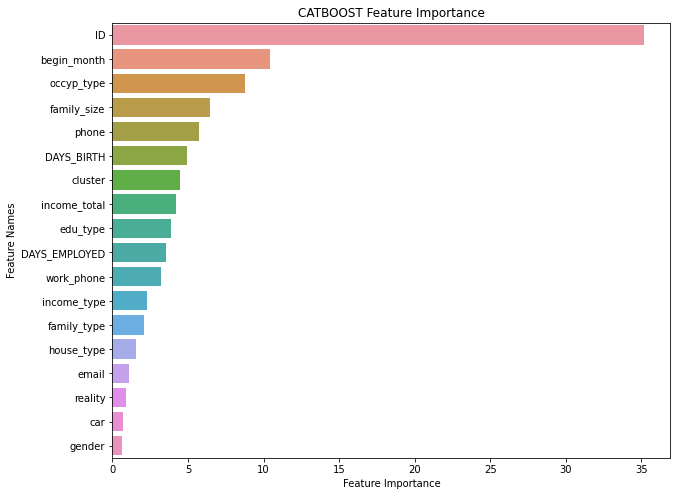

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

# 모델링-2 (CatBoost)
- 소수점 첫 째 자리까지 표현

In [ ]:
features = ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']

for df in [train, test]:
    # 소수점 첫 째 자리까지
    for feat in features:
        df[feat] = round(df[feat], 1)

## 클러스터링
- 분류 모형을 총 36개로 나누어본다.
- n_clusters = 36

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [ ]:
train['cluster'].value_counts()

0     1023
35     961
30     957
10     952
21     942
20     923
28     913
7      912
22     883
12     868
27     827
4      824
33     819
5      817
14     816
31     812
34     795
15     787
23     782
8      775
19     750
11     750
2      741
25     729
1      694
26     626
17     602
9      581
18     538
24     524
3      460
32     458
13     453
29     400
6      385
16     372
Name: cluster, dtype: int64

## StandardScale
- categorical_feats는 제외
- 이미 로그변환을 마친 아래 컬럼 제외
- income_total, DAYS_EMOPLOYED, DAYS_BIRTH, begin_month

In [ ]:
from sklearn.preprocessing import StandardScaler
import multiprocessing

In [ ]:
print(categorical_feats)
print(numerical_feats)

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
['gender', 'car', 'reality', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'family_size', 'begin_month']


In [ ]:
categorical = ['gender' , 'car','reality']

In [ ]:
for i in categorical:
    numerical_feats.remove(i)

scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
train.head(2)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID,cluster
0,0,0,0,0.379542,1,1,1,1,-0.518564,0.809389,-0.538321,-0.645632,-0.316977,1,-0.216262,-1.287742,1.0,1,0
1,0,0,1,0.791984,1,2,2,2,-1.249528,0.363207,-0.538321,-0.645632,3.154805,2,0.897294,-1.545753,1.0,2,0


## CAT BOOST
- cat_feature가 중요한 듯!
    - cat_feature에는 categorical 변수로 이루어져야 함
- default parameter로 진행
    - 다음 모델에서 parmeter 튜닝해보자

In [ ]:
!pip install catboost
!pip install category_encoders
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [ ]:
# one of the parameters : cat_features
categorical_feats

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

### n_fold = 15
- Log Loss : 0.66685

In [ ]:
# n_fold를 돌려보고 좋은 수치를 선택
# 15가 가장 좋은 성능을 냈다.
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346971	test: 1.0334162	best: 1.0334162 (0)	total: 171ms	remaining: 2m 50s
100:	learn: 0.7071842	test: 0.6418762	best: 0.6415440 (88)	total: 13.9s	remaining: 2m 3s
200:	learn: 0.6908005	test: 0.6398574	best: 0.6396445 (189)	total: 25.3s	remaining: 1m 40s
300:	learn: 0.6741861	test: 0.6390778	best: 0.6385622 (259)	total: 36.6s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6385622087
bestIteration = 259

Shrink model to first 260 iterations.
CV Log Loss Score: 0.638562

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346136	test: 1.0339979	best: 1.0339979 (0)	total: 64.6ms	remaining: 1m 4s
100:	learn: 0.7065314	test: 0.6731358	best: 0.6730786 (99)	total: 10.2s	remaining: 1m 31s
200:	learn: 0.6894220	test: 0.6716324	best: 0.6712088 (135)	total: 21.8s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

b

#### Feature Importance

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

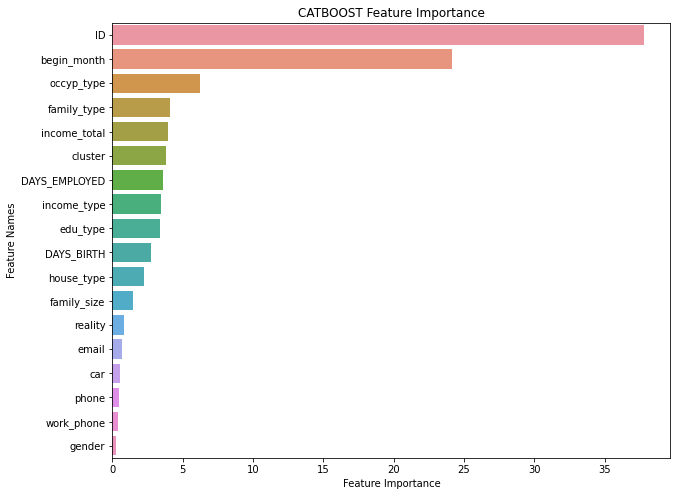

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

# feature_set_2 평가
- 모델링-1
    - 타겟 변수의 자료 불균형을 해소하고자 샘플링을 결정했다.
    - 하지만 샘플링의 효과는 과대적합을 불러왔다.
- 모델링-2
    - 샘플링을 진행하지 않아서 과대적합의 문제를 해결했다.
    - Default Parmeter도 좋은 성능을 낸다.
    - 다음 feature set에서는 numerical & categorical feature를 부각시킨 다음 비교해보자
    - Public 0.66685점, 14등
- ID 변수 생성
    - ID 변수란 train 데이터에서 변수(자녀 수, 가족 수, 나이, 근무 일 등등)들이 중복되는 자료가 몇몇 보여서 생성한 변수이다.
    - 모든 모델링에서 ID 변수의 중요도가 높게 측정되었다.
    - 하지만 완전히 새로운 자료가 주어진다면 판단 확률은 높지 않을 것이라 예상한다.

# Submission

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/data/credit/rawData/sample_submission.csv')

In [ ]:
sub.iloc[:, 1:] = cat_pred_test

In [ ]:
sub

,index,0,1,2
0,26457,0.118312,0.169057,0.712632
1,26458,0.349234,0.230024,0.420741
2,26459,0.035505,0.071770,0.892725
3,26460,0.054222,0.076360,0.869418
4,26461,0.082895,0.223916,0.693189
...,...,...,...,...
9995,36452,0.075798,0.236220,0.687983
9996,36453,0.345406,0.184089,0.470505
9997,36454,0.049072,0.116586,0.834343
9998,36455,0.142140,0.310481,0.547379


In [ ]:
sub.to_csv('/content/drive/MyDrive/data/credit/submission/submission_version_2_M4_nfold_20.csv', index=False)